<div style="font-size:37px; font-weight:bold; line-height:1.1">
    Computer-aided exploration of the Martian geology
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
<br>
Copyright (c) 2018 Massachusetts Institute of Technology
</p>
<p style="color:rgb(90,90,90);">
Author: Guillaume Rongier
<br>
We acknowledge support from NSF ACI1442997 (PI: V. Pankratius) and NASA AISTNNX15AG84G (PI: V. Pankratius).
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook is part of a set of notebooks to compute a favorability map for the selection of landing sites on Mars. A favorable site depends on two main constraints:
* Landing constraints which ensure that the system can land on a given area.
* Scientific targets which must be visited by a rover after landing, if the rover can drive to them.

The notebooks determine this favorability for a rover similar to NASA's Mars 2020 rover at 20 pixels per degree (3 km per pixel at the equator), and investigate our ability to explore Mars with enhanced landing and roving capabilities.

# Fuzzification and fuzzy combination of the landing constraints

Our goal here is to combine all the rasters corresponding to the engineering constraints and high-resolution data into a single map of raw landing favorability. To do so, we use fuzzy logic [[Zadeh, 1965](http://doi.org/10.1016/S0019-9958(65%2990241-X)], which is based on two steps: fuzzification and fuzzy combination.

## Package imports

Load some functions for data import, data visualization, and favorability computation.

In [1]:
%matplotlib notebook

from skdiscovery.utilities.planetary.raster_management import *
from skdiscovery.utilities.planetary.fuzzy_logic import *

import matplotlib.pyplot as plt

## Setting

Geographical setting for the rasters.

In [2]:
mars_radius = 3389500. # meters

master_lon_min = -180.
master_lon_max = 180.
master_lat_min = -90.
master_lat_max = 90.
master_extent = (master_lon_min, master_lon_max, master_lat_min, master_lat_max)

master_width = 7200
master_height = 3600
master_geotransform = define_geotransform(master_lon_min, master_lon_max, 
                                          master_lat_min, master_lat_max, 
                                          master_width, master_height)
master_projection = '''PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0]]'''

master_spatial_reference_system = osr.SpatialReference(wkt = master_projection)
master_central_meridian = 0.

Folder structure from the base folder *CaseStudyMars_Data*:
<pre>
Base folder:   CaseStudyMars_Data/
               ├── Original_Data/
               │   ├── Interpreted_Data/
               │   ├── MEX/
               │   │   ├── HRSC/
               │   │   └── OMEGA/
               │   ├── MGS/
               │   │   ├── MOLA/
               │   │   └── TES/
               │   ├── MRO/
               │   │   ├── CRISM/
               │   │   └── HiRISE/
Output folder: └── Raster_Data_20ppd/
</pre>

In [3]:
base_folder = '/data/Mars/CaseStudyMars_Data/'
output_folder = 'Raster_Data_20ppd/'

Define the minimal value of the fuzzified maps.

In [4]:
bottom_value = 0

## Fuzzification of the raster maps

Fuzzification simply consists in ranging the rasters between 0 and 1, 0 being unfavorable and 1 being favorable. The function doing the ranging is called a membership function. We use a trapezoidal function as basis for the membership functions, because it adapts well to many cases while its parameters remain easy to set.

For each data, we use values from NASA's Mars Science Laboratory (Curiosity program) and NASA's Mars 2020 rover, both programs having similar characterisitics. These values are used to define the membership functions from their trapezoidal basis.

### Engineering constraints

**Latitude**  
<br>
<dl>
  <dt>MSL</dt>
  <dd>30&deg;S &le; latitude &le; 30&deg;N (initially &#xb1;60&deg;, then &#xb1;45&deg;, and finally &#xb1;30&deg;) [[Golombek et al., 2012](http://doi.org/10.1007/s11214-012-9916-y)]</dd>
  <dd>&#xb1;45&deg; excludes the possibility of ground ice within 1 m of typical flat surfaces, for planetary protection [[Golombek et al., 2012](http://doi.org/10.1007/s11214-012-9916-y)]</dd>
  <dt>Mars 2020</dt>
  <dd>30&deg;S &le; latitude &le; 30&deg;N [[Mustard et al., 2013](http://www.researchgate.net/publication/259219062_Report_of_the_Mars_2020_Science_Definition_Team)]</dd>
</dl>

In [5]:
raster_latitude = open_raster(base_folder + output_folder + 'Other_Data_Latitude.tif')
print_raster_info(raster_latitude)
raster_latitude_array = get_raster_array(raster_latitude)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


In [6]:
raster_latitude_array = trapezoidal_function(raster_latitude_array, -45, -30, 30, 45,
                                             bottom_value = bottom_value, plateau_value = 1, nan_value = 0)

**Elevation**  
<br>
<dl>
  <dt>MSL</dt>
  <dd>MOLA elevation &lt; -1 km (initially 2.5 km, restricted to 1 km, then 0 km and finally -1 km) [[Golombek et al., 2012](http://doi.org/10.1007/s11214-012-9916-y)]</dd>
  <dt>Mars 2020</dt>
  <dd>MOLA elevation &lt; -0.5 km, with respect to the MOLA geoid, but the system would likely be capable of landing at site elevations up to 0.5 km (1 km of margin) [[Mustard et al., 2013](http://www.researchgate.net/publication/259219062_Report_of_the_Mars_2020_Science_Definition_Team)]</dd>
</dl>

In [7]:
raster_elevation = open_raster(base_folder + output_folder + 'MGS_MOLA_Elevation.tif')
print_raster_info(raster_elevation)
raster_elevation_array = get_raster_array(raster_elevation)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


In [8]:
raster_elevation_array = trapezoidal_function(raster_elevation_array, -10000, -10000, -500, 500,
                                              bottom_value = bottom_value, plateau_value = 1, nan_value = 0)

**Standard deviation of elevation at 1 km baseline**  
<br>
<dl>
  <dt>MSL</dt>
  <dd>100-130 m of relief for 1000 m (initially 43 m of relief for 1000 m, i.e., 2.5&deg;) [[Golombek et al., 2012](http://doi.org/10.1007/s11214-012-9916-y)]<dd>
  <dt>Mars 2020</dt>
  <dd>Same as MSL [http://marsnext.jpl.nasa.gov/scieng_eng.cfm]</dd>
</dl>

In [9]:
raster_std_elevation_1km = open_raster(base_folder + output_folder + 'MGS_MOLA_Std_Elevation_1km.tif')
print_raster_info(raster_std_elevation_1km)
raster_std_elevation_1km_array = get_raster_array(raster_std_elevation_1km)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


In [10]:
raster_std_elevation_1km_array = trapezoidal_function(raster_std_elevation_1km_array, 0, 0, 100, 130,
                                                      bottom_value = bottom_value, plateau_value = 1, nan_value = 0)

**Standard deviation of elevation at 2 km baseline**  
<br>
<dl>
  <dt>MSL</dt>
  <dd>43-720 m of relief for 2000 m [MSL Project, 2007, http://marsoweb.nas.nasa.gov/landingsites/msl/memoranda/MSL_Eng_User_Guide_v4.5.1.pdf]<dd>
  <dt>Mars 2020</dt>
</dl>

In [11]:
raster_std_elevation_2km = open_raster(base_folder + output_folder + 'MGS_MOLA_Std_Elevation_2km.tif')
print_raster_info(raster_std_elevation_2km)
raster_std_elevation_2km_array = get_raster_array(raster_std_elevation_2km)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


In [12]:
raster_std_elevation_2km_array = trapezoidal_function(raster_std_elevation_2km_array, 0, 0, 130, 720,
                                                      bottom_value = bottom_value, plateau_value = 1, nan_value = 0)

**Slope at 1 km baseline**  
<br>
<dl>
  <dt>MSL</dt>
  <dd>slope 2-5 m &lt; 30&deg; (initially 15&deg;) [[Golombek et al., 2012](http://doi.org/10.1007/s11214-012-9916-y)]</dd>
  <dd>100-130 m of relief for 1000 m, i.e., slope 1-1000 m &lt; 5.7-7.4&deg; (initially 43 m of relief for 1000 m, i.e., 2.5&deg;) [[Golombek et al., 2012](http://doi.org/10.1007/s11214-012-9916-y)]<dd>
  <dd>slope 2-5 m &lt; 15&deg; [[Mustard et al., 2013](http://www.researchgate.net/publication/259219062_Report_of_the_Mars_2020_Science_Definition_Team)]</dd>
  <dd>slope 2-10 km &lt; 2&deg; [[Mustard et al., 2013](http://www.researchgate.net/publication/259219062_Report_of_the_Mars_2020_Science_Definition_Team)]</dd>
  <dt>Mars 2020</dt>
  <dd>Same as MSL [http://marsnext.jpl.nasa.gov/scieng_eng.cfm]</dd>
</dl>

In [13]:
raster_slope_1km = open_raster(base_folder + output_folder + 'MGS_MOLA_Slope_1km.tif')
print_raster_info(raster_slope_1km)
raster_slope_1km_array = get_raster_array(raster_slope_1km)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


In [14]:
raster_slope_1km_array = trapezoidal_function(raster_slope_1km_array, -10000, -10000, 2, 2.5,
                                              bottom_value = bottom_value, plateau_value = 1, nan_value = 0)

**Thermophysical surface units**  
<br>
<dl>
  <dt>MSL</dt>
  <dd>100 Jm<sup>−2</sup>s<sup>−0.5</sup>K<sup>−1</sup> &le; thermal inertia [[Golombek et al., 2012](http://doi.org/10.1007/s11214-012-9916-y)]</dd>
  <dd>albedo &le; 0.25 [[Golombek et al., 2012](http://doi.org/10.1007/s11214-012-9916-y)]</dd>
  <dd>Corresponds to Class A of the thermophysical surface units [[Putzig et al., 2005](http://doi.org/10.1016/j.icarus.2004.08.017)]
  <dt>Mars 2020</dt>
  <dd>100 Jm<sup>−2</sup>s<sup>−0.5</sup>K<sup>−1</sup> &le; thermal inertia, surfaces with thermal inertia &lt; 150 Jm<sup>−2</sup>s<sup>−0.5</sup>K<sup>−1</sup> and high albedo may also be dusty and should be further investigated [http://marsnext.jpl.nasa.gov/scieng_eng.cfm]</dd>
  <dd>Same albedo as MSL [http://marsnext.jpl.nasa.gov/scieng_eng.cfm]</dd>
</dl>

In [15]:
raster_thermophy = open_raster(base_folder + output_folder + 'MGS_TES_Thermophysical_Surface_Units.tif')
print_raster_info(raster_thermophy)
raster_thermophy_array = get_raster_array(raster_thermophy)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


In [16]:
favorable_indices = np.where((raster_thermophy_array == 2) | 
                             (raster_thermophy_array == 3) | 
                             (raster_thermophy_array == 5) | 
                             (raster_thermophy_array == 6))
nonfavorable_indices = np.where((raster_thermophy_array == 1) | 
                                (raster_thermophy_array == 4) | 
                                (raster_thermophy_array == 7))

raster_thermophy_array[favorable_indices] = 1.
raster_thermophy_array[nonfavorable_indices] = bottom_value
raster_thermophy_array[np.isnan(raster_thermophy_array)] = 0.

### High-resolution data

Here the rasters are directly between 0 and 1 from the rasterization, so no further processing is needed.

**HiRISE DTM**

In [17]:
raster_hirise_dtm_footprints = open_raster(base_folder + output_folder + 'MRO_HiRISE_DTM_Rasterized_Footprints.tif')
print_raster_info(raster_hirise_dtm_footprints)
raster_hirise_dtm_footprints_array = get_raster_array(raster_hirise_dtm_footprints)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


**HRSC DTM**

In [18]:
raster_hrsc_footprints = open_raster(base_folder + output_folder + 'MEX_HRSC_Rasterized_Footprints.tif')
print_raster_info(raster_hrsc_footprints)
raster_hrsc_footprints_array = get_raster_array(raster_hrsc_footprints)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


**HiRISE RDR**

In [19]:
raster_hirise_footprints = open_raster(base_folder + output_folder + 'MRO_HiRISE_Rasterized_Footprints.tif')
print_raster_info(raster_hirise_footprints)
raster_hirise_footprints_array = get_raster_array(raster_hirise_footprints)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


## Fuzzy combination of the fuzzified maps

Fuzzy combination performs the actual combination of the data into a single map using element-wise operators, called fuzzy operators. Six fuzzy operators can be used:
* The complement, corresponding to the "not" operation:  
$\mu_{c} = 1 - \mu$  
with $\mu$ the value of a fuzzified data set at a given cell, and $\mu_{c}$ the value for that cell.  
* The intersection, corresponding to the "and" operation:  
$\mu_{c} = \min(\mu_{1}, \dotsc, \mu_{n})$  
with $\mu_{i}$ the value of the fuzzified data set $i$ at a given cell, and $\mu_{c}$ the combined value for that cell.  
* The union, corresponding to the "or" operation:  
$\mu_{c} = \max(\mu_{1}, \dotsc, \mu_{n})$  
with $\mu_{i}$ the value of the fuzzified data set $i$ at a given cell, and $\mu_{c}$ the combined value for that cell.  
* The gamma operator:  
$\mu_{c} = \left(1 - \prod_{i=1}^{n}\left(1-\mu_{i}\right) \right)^{\gamma}\left(\prod_{i=1}^{n}\left(\mu_{i}\right) \right)^{1-\gamma}$  
with $\mu_{i}$ the value of the fuzzified data set $i$ at a given cell, and $\mu_{c}$ the combined value for that cell. When $\gamma = 1$, the gamma operator is equivalent to the algebraic sum. When $\gamma = 0$, the gamma operator is equivalent to the algebraic product. The algebraic sum is an increasive operator and results in an higher value than the maximum value, so higher than the union. The algebraic product is a decreasive operator and results in a lower value than the minimum value, so lower than the intersection.  

### Engineering constraints

We want to know from the engineering constraints where it should be safe to land. Thus, we want the intersection of all the favorable areas from each constraint. The algebraic product allows us to take into account the values from all the constraints at a given cell (the intersection, instead, only takes one value into account, the minimum). Thus, a cell with a very low value for a constraint but high values for the other constraints will not have the same favorability than a cell with the same very low value for the same constraint but low values for the other constraints.

In [20]:
engineering_constraints_array = algebraic_product(raster_latitude_array,
                                                  raster_elevation_array,
                                                  raster_std_elevation_1km_array,
                                                  raster_std_elevation_2km_array,
                                                  raster_slope_1km_array,
                                                  raster_thermophy_array)

<IPython.core.display.Javascript object>


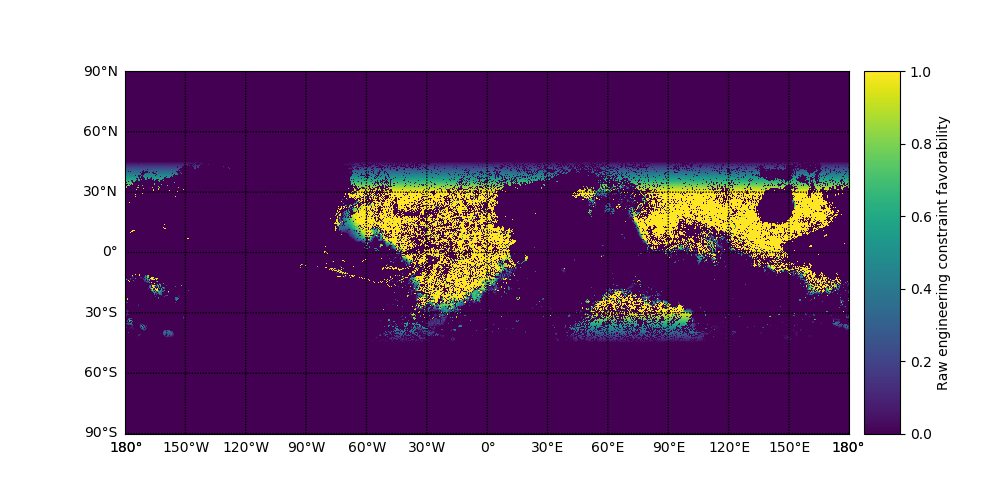

In [21]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection = 'cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, engineering_constraints_array, 'Raw engineering constraint favorability')
basemap1.drawmeridians(np.arange(0, 360, 30), labels = [False, False, False, True])
basemap1.drawparallels(np.arange(-90, 91, 30), labels = [True, False, False, False])
plt.show()

### High-resolution data

The high-resolution data are combined in two steps. A first step combine all the areas where high-resolution digital terrain models are available. A second step adds the HiRISE visible images. The greater number of HiRISE RDR images compared to the HiRISE DTM can help in two ways: either computing a new digital terrain model if two HiRISE images are close enough to be used as stereo, or doing some analysis directly on the RDR image [e.g., [Golombek et al., 2012](http://doi.org/10.1007/s11214-012-9916-y)].

In [22]:
high_resolution_data_array = union(raster_hirise_dtm_footprints_array,
                                   raster_hrsc_footprints_array)
high_resolution_data_array = gamma_operation(0.9, high_resolution_data_array,
                                             raster_hirise_footprints_array)

<IPython.core.display.Javascript object>


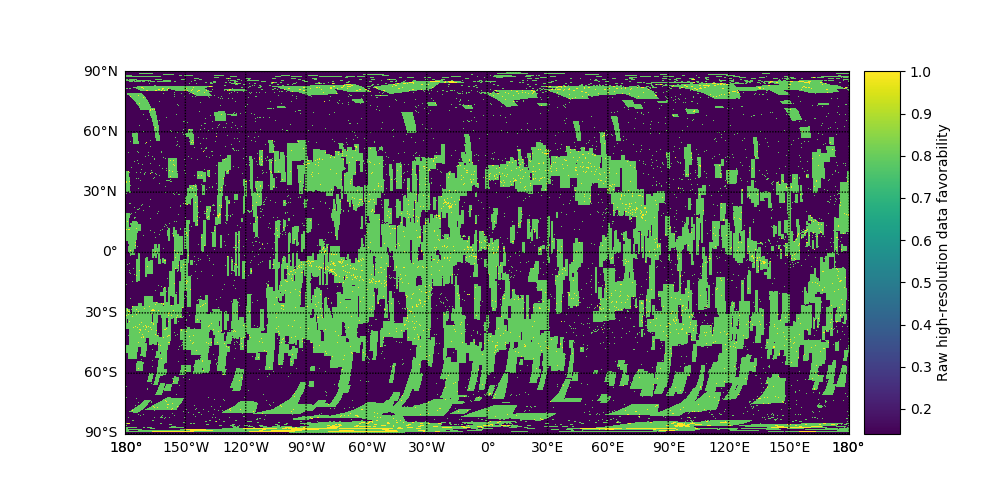

In [23]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection = 'cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, high_resolution_data_array, 'Raw high-resolution data favorability')
basemap1.drawmeridians(np.arange(0, 360, 30), labels = [False, False, False, True])
basemap1.drawparallels(np.arange(-90, 91, 30), labels = [True, False, False, False])
plt.show()

### Engineering constraints and high-resolution data

The combination between the engineering constraints and the high-resolution data aims at highlighting the areas where landing should be safe and where some high-resolution data are available to perform more local and detailed studies. The areas where landing should be safe but with no high-resolution data must not be labelled as unfavorable, but rather have a slightly lower favorability. Hence the use of a gamma operation with a high value for gamma.

In [24]:
engineering_constraints_array = algebraic_product(raster_latitude_array,
                                                  raster_elevation_array,
                                                  raster_std_elevation_1km_array,
                                                  raster_std_elevation_2km_array,
                                                  raster_slope_1km_array,
                                                  raster_thermophy_array)

high_resolution_data_array = union(raster_hirise_dtm_footprints_array,
                                   raster_hrsc_footprints_array)
high_resolution_data_array = gamma_operation(0.9, high_resolution_data_array,
                                             raster_hirise_footprints_array)

landing_array = gamma_operation(0.9, engineering_constraints_array, high_resolution_data_array)

<IPython.core.display.Javascript object>


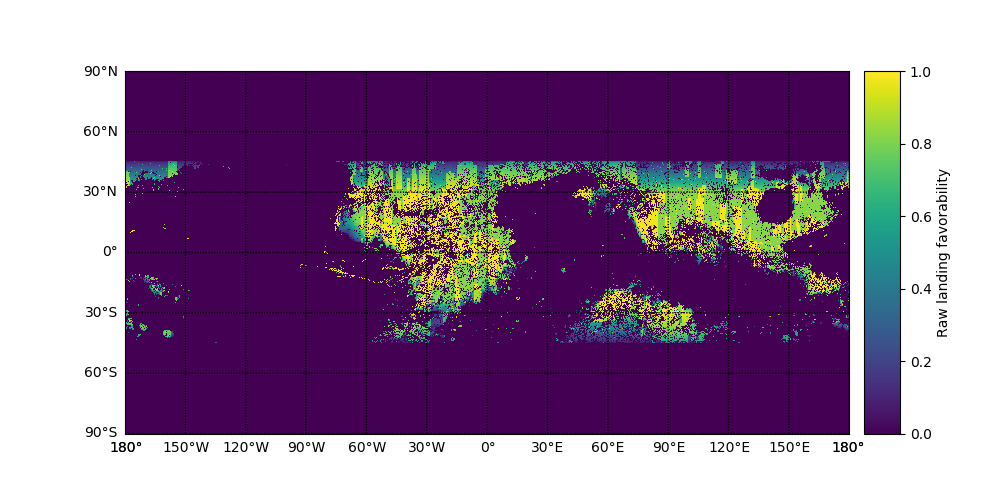

In [25]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection = 'cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, landing_array, 'Raw landing favorability')
basemap1.drawmeridians(np.arange(0, 360, 30), labels = [False, False, False, True])
basemap1.drawparallels(np.arange(-90, 91, 30), labels = [True, False, False, False])
plt.show()

In [26]:
raster_landing = create_raster_from_array(landing_array,           
                                          master_geotransform, 
                                          master_projection,
                                          file_type = 'GTiff',
                                          file_path = base_folder + output_folder + 'Results_RawFavorability_Landing.tif',
                                          options = ['COMPRESS=DEFLATE', 'PREDICTOR=3', 'TILED=YES'])
print_raster_info(raster_landing)
raster_landing = None

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )
